In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math

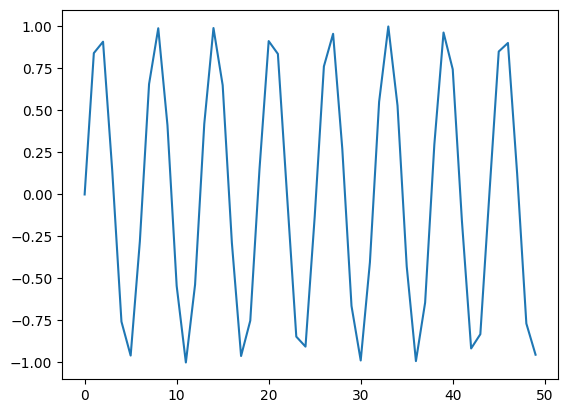

In [2]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

# Visualizing the sine wave we’ve just generated:
plt.plot(sin_wave[:50]) # plot the sine wave

In [3]:
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [4]:
# Print the shape of the data:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [5]:
# Note that we looped for (num_records – 50), because we want to set aside 50 records as our validation data.
# We can create this validation data now:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])

X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [6]:
learning_rate = 0.0001
nepoch = 10
T = 50 # length of sequence
hidden_dim = 100
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

# We will then define the weights of the network:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [8]:
for epoch in range(nepoch):
    # 1.) check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev_s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        # calculate training error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
        
    loss = loss / float(y.shape[0])
    
    # 2.) check loss on validation
    val_loss = 0.0
    for i in range(Y_val.shape[0]):
        x, y = X_val[i], Y_val[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
        
        # calculate validation error 
        loss_per_record = (y - mulv)**2 / 2
        val_loss += loss_per_record
        
    val_loss = val_loss / float(y.shape[0])

    print('Epoch: ', epoch + 1, ', Training Loss: ', loss, ', Validation Loss: ', val_loss)
    
    # 3.) Train the model
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
    
        layers = []
        prev_s = np.zeros((hidden_dim, 1))
        dU = np.zeros(U.shape)
        dV = np.zeros(V.shape)
        dW = np.zeros(W.shape)
        
        dU_t = np.zeros(U.shape)
        dV_t = np.zeros(V.shape)
        dW_t = np.zeros(W.shape)
        
        dU_i = np.zeros(U.shape)
        dW_i = np.zeros(W.shape)
        
        # forward pass
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            layers.append({'s':s, 'prev_s':prev_s})
            prev_s = s
            
        # derivative of pred
        dmulv = (mulv - y)
        
        # backward pass
        for t in range(T):
            dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
            dsv = np.dot(np.transpose(V), dmulv)
            
            ds = dsv
            dadd = add * (1 - add) * ds
            
            dmulw = dadd * np.ones_like(mulw)

            dprev_s = np.dot(np.transpose(W), dmulw)


            for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
                ds = dsv + dprev_s
                dadd = add * (1 - add) * ds

                dmulw = dadd * np.ones_like(mulw)
                dmulu = dadd * np.ones_like(mulu)

                dW_i = np.dot(W, layers[t]['prev_s'])
                dprev_s = np.dot(np.transpose(W), dmulw)

                new_input = np.zeros(x.shape)
                new_input[t] = x[t]
                dU_i = np.dot(U, new_input)
                dx = np.dot(np.transpose(U), dmulu)

                dU_t += dU_i
                dW_t += dW_i
                
            dV += dV_t
            dU += dU_t
            dW += dW_t
            
            if dU.max() > max_clip_value:
                dU[dU > max_clip_value] = max_clip_value
            if dV.max() > max_clip_value:
                dV[dV > max_clip_value] = max_clip_value
            if dW.max() > max_clip_value:
                dW[dW > max_clip_value] = max_clip_value
                
            
            if dU.min() < min_clip_value:
                dU[dU < min_clip_value] = min_clip_value
            if dV.min() < min_clip_value:
                dV[dV < min_clip_value] = min_clip_value
            if dW.min() < min_clip_value:
                dW[dW < min_clip_value] = min_clip_value
        
        # update
        U -= learning_rate * dU
        V -= learning_rate * dV
        W -= learning_rate * dW

Epoch:  1 , Training Loss:  [[149292.14707237]] , Validation Loss:  [[74643.92618101]]
Epoch:  2 , Training Loss:  [[99653.84198777]] , Validation Loss:  [[49825.15941277]]
Epoch:  3 , Training Loss:  [[60015.53690266]] , Validation Loss:  [[30006.39264428]]
Epoch:  4 , Training Loss:  [[30377.22721833]] , Validation Loss:  [[15187.62357271]]
Epoch:  5 , Training Loss:  [[10719.68056462]] , Validation Loss:  [[5359.2103232]]
Epoch:  6 , Training Loss:  [[652.06771857]] , Validation Loss:  [[325.72686155]]
Epoch:  7 , Training Loss:  [[26.67413712]] , Validation Loss:  [[13.30920213]]
Epoch:  8 , Training Loss:  [[27.35796339]] , Validation Loss:  [[13.65416086]]
Epoch:  9 , Training Loss:  [[27.34957724]] , Validation Loss:  [[13.64959375]]
Epoch:  10 , Training Loss:  [[27.45277928]] , Validation Loss:  [[13.69589425]]


In [9]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

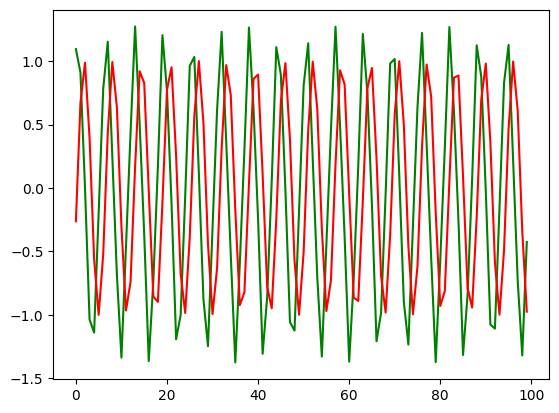

In [10]:
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

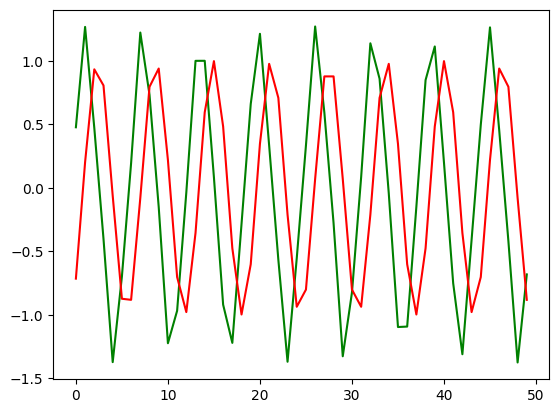

In [12]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

## Sentiment Analysis

In [19]:
import numpy as np
# !unzip data.zip
# !rm data.zip

In [20]:
with open('data/reviews.txt', 'r') as f:
    reviews = f.read()
with open('data/labels.txt', 'r') as f:
    labels = f.read()

reviews[:2000]

'bromwell high is a cartoon comedy . it ran at the same time as some other programs about school life  such as  teachers  . my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers  . the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students . when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled . . . . . . . . . at . . . . . . . . . . high . a classic line inspector i  m here to sack one of your teachers . student welcome to bromwell high . i expect that many adults of my age think that bromwell high is far fetched . what a pity that it isn  t   \nstory of a man who has unnatural feelings for a pig . starts out with a opening scene that is a terrific example of absurd comedy . a formal orchestra audience is tu

In [21]:
from string import punctuation
all_text = ''.join([c for c in reviews if c not in punctuation])
reviews = all_text.split('\n')

all_text = ' '.join(reviews)
words = all_text.split()

all_text[:2000]

'bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t    story of a man who has unnatural feelings for a pig  starts out with a opening scene that is a terrific example of absurd comedy  a formal orchestra audience is turned into an insane  violent m

In [22]:
print('Reveiws class:', type(reviews))
print('Number of reviews:', len(reviews))
print('First Review:', reviews[0])
print('Last Review:', reviews[25000])

Reveiws class: <class 'list'>
Number of reviews: 25001
First Review: bromwell high is a cartoon comedy  it ran at the same time as some other programs about school life  such as  teachers   my   years in the teaching profession lead me to believe that bromwell high  s satire is much closer to reality than is  teachers   the scramble to survive financially  the insightful students who can see right through their pathetic teachers  pomp  the pettiness of the whole situation  all remind me of the schools i knew and their students  when i saw the episode in which a student repeatedly tried to burn down the school  i immediately recalled          at           high  a classic line inspector i  m here to sack one of your teachers  student welcome to bromwell high  i expect that many adults of my age think that bromwell high is far fetched  what a pity that it isn  t   
Last Review: 


In [23]:
from collections import Counter

# Create a Counter object to count the word occurrences in your data
counts = Counter(words)

# Sort the words in descending order by their frequency
vocab = sorted(counts, key=counts.get, reverse=True)

# Create a dictionary that maps words to integers starting from 1
vocab_to_int = {word: i for i, word in enumerate(vocab, 1)}

# Convert the reviews to integers and store them in reviews_ints
reviews_ints = []
for review in reviews:
    reviews_ints.append([vocab_to_int[word] for word in review.split()])

In [24]:
import numpy as np

# Assuming 'labels' is a list of labels like ['positive', 'negative', 'positive', ...]
labels = labels.split('\n')

# Convert labels to 1 for 'positive' and 0 for 'negative'
labels = np.array([1 if label == 'positive' else 0 for label in labels])

In [25]:
review_lens = Counter([len(x) for x in reviews_ints])
print("Zero-length reviews: {}".format(review_lens[0]))
print("Maximum review length: {}".format(max(review_lens)))

Zero-length reviews: 1
Maximum review length: 2514


In [26]:
# Filter out reviews with a length of 0
non_zero_idx = [i for i, review in enumerate(reviews_ints) if len(review) != 0]
reviews_ints = [reviews_ints[i] for i in non_zero_idx]
labels = np.array([labels[i] for i in non_zero_idx])

In [27]:
seq_len = 200

features = np.zeros((len(reviews_ints), seq_len), dtype=int)
for i, review in enumerate(reviews_ints):
    features[i, -len(review):] = np.array(review)[:seq_len]

In [28]:
split_frac = 0.8

# Split data into training, validation, and test sets
split_idx = int(len(features) * split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

# Split the remaining data equally into validation and test sets
split_idx = int(len(remaining_x) * 0.5)
val_x, test_x = remaining_x[:split_idx], remaining_x[split_idx:]
val_y, test_y = remaining_y[:split_idx], remaining_y[split_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), "\nValidation set: \t{}".format(val_x.shape), "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(20000, 200) 
Validation set: 	(2500, 200) 
Test set: 		(2500, 200)


In [29]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
learning_rate = 0.001

In [30]:
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

n_words = len(vocab_to_int)

# Create the graph object
graph = tf.Graph()

# Add nodes to the graph
with graph.as_default():
    with tf.name_scope("inputs"):
        inputs_ = tf.placeholder(tf.int32, [None, None], name="inputs")
        
    with tf.name_scope("labels"):
        labels_ = tf.placeholder(tf.int32, [None, None], name="labels")
        
    keep_prob = tf.placeholder(tf.float32, name="keep_prob")

C:\Users\Savi\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [31]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 

with graph.as_default():
    with tf.device('/cpu:0'):
        with tf.name_scope("embedding"):
            embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
            embed = tf.nn.embedding_lookup(embedding, inputs_)
            tf.summary.histogram("word_embedding", embedding)

In [32]:
with graph.as_default():
    with tf.name_scope("RNN_layers"):
        # Your basic LSTM cell
        lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)
        
        # Add dropout to the cell
        drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
        
        # Stack up multiple LSTM layers, for deep learning
        cell = tf.nn.rnn_cell.MultiRNNCell([drop] * lstm_layers)
        
        # Getting an initial state of all zeros
        initial_state = cell.zero_state(batch_size, tf.float32)

C:\Users\Savi\AppData\Local\Temp\ipykernel_3584\1587791531.py:4: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)


## Forward Pass

In [33]:
with graph.as_default():
    # Create an RNN layer by using tf.nn.dynamic_rnn
    outputs, final_state = tf.nn.dynamic_rnn(drop, embed, dtype=tf.float32)

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [34]:
with graph.as_default():
    with tf.name_scope("predictions"):
        predictions = tf.layers.dense(outputs[:, -1], 1, activation=tf.nn.sigmoid)
        tf.summary.histogram("predictions", predictions)
        
    with tf.name_scope("cost"):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar("cost", cost)
        
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

C:\Users\Savi\AppData\Local\Temp\ipykernel_3584\3859442585.py:3: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  predictions = tf.layers.dense(outputs[:, -1], 1, activation=tf.nn.sigmoid)


In [35]:
with graph.as_default():
    with tf.name_scope("train"):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        tf.summary.scalar("accuracy", accuracy)
        
    merged = tf.summary.merge_all()

In [36]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [37]:
epochs = 10

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    train_writer = tf.summary.FileWriter("./logs/2/train", sess.graph)
    test_writer = tf.summary.FileWriter("./logs/2/test")
    iteration = 1
    for e in range(epochs):
        state = sess.run(initial_state)
        
        for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
            feed = {inputs_: x,
                    labels_: y[:, None],
                    keep_prob: 0.5,
                    initial_state: state}
            summary, loss, state, _ = sess.run([merged, cost, final_state, optimizer], feed_dict=feed)
            
            if iteration%5==0:
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Train loss: {:.3f}".format(loss))
                train_writer.add_summary(summary, iteration)

            if iteration%25==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(val_x, val_y, batch_size):
                    feed = {inputs_: x,
                            labels_: y[:, None],
                            keep_prob: 1,
                            initial_state: val_state}
                    summary, batch_acc, val_state = sess.run([merged, accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.3f}".format(np.mean(val_acc)))
                test_writer.add_summary(summary, iteration)
            iteration +=1
    saver.save(sess, "checkpoints/sentiment.ckpt")

Epoch: 0/10 Iteration: 5 Train loss: 0.241
Epoch: 0/10 Iteration: 10 Train loss: 0.238
Epoch: 0/10 Iteration: 15 Train loss: 0.223
Epoch: 0/10 Iteration: 20 Train loss: 0.227
Epoch: 0/10 Iteration: 25 Train loss: 0.208
Val acc: 0.733
Epoch: 0/10 Iteration: 30 Train loss: 0.176
Epoch: 0/10 Iteration: 35 Train loss: 0.181
Epoch: 0/10 Iteration: 40 Train loss: 0.188
Epoch: 1/10 Iteration: 45 Train loss: 0.148
Epoch: 1/10 Iteration: 50 Train loss: 0.167
Val acc: 0.765
Epoch: 1/10 Iteration: 55 Train loss: 0.155
Epoch: 1/10 Iteration: 60 Train loss: 0.142
Epoch: 1/10 Iteration: 65 Train loss: 0.127
Epoch: 1/10 Iteration: 70 Train loss: 0.144
Epoch: 1/10 Iteration: 75 Train loss: 0.119
Val acc: 0.788
Epoch: 1/10 Iteration: 80 Train loss: 0.146
Epoch: 2/10 Iteration: 85 Train loss: 0.117
Epoch: 2/10 Iteration: 90 Train loss: 0.122
Epoch: 2/10 Iteration: 95 Train loss: 0.132
Epoch: 2/10 Iteration: 100 Train loss: 0.125
Val acc: 0.796
Epoch: 2/10 Iteration: 105 Train loss: 0.114
Epoch: 2/10 Ite

In [45]:
import tensorflow as tf

with tf.compat.v1.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(initial_state)  # Use initial_state defined in the graph
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)


INFO:tensorflow:Restoring parameters from checkpoints\sentiment.ckpt
